# Part 1: Setup

## Install and load libraries, API keys, and project directories

In [ ]:
# !pip uninstall httpx
!pip install --upgrade openai
!pip install httpx==0.27.2
!pip install langchain mistralai requests
!pip install langchain_openai google-search-results langchain
!pip install -U langchain-community
!pip install langchain-core
!pip install langchain_mistralai
!pip install langchain_deepseek
# !pip install seaborn


In [4]:
import json
import os
import time
import re
import requests
import urllib.request
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain_mistralai import ChatMistralAI
from langchain_deepseek import ChatDeepSeek
from langchain_core.prompts import ChatPromptTemplate
from google.colab import userdata

import openai
from openai import OpenAI

In [5]:
openai_api_key = userdata.get('OPENAI_API_KEY')
mistral_api_key = userdata.get('MISTRAL_API_KEY')
rapidapi_key = userdata.get('RAPIDAPI_KEY')
deepseek_api_key = userdata.get('DEEPSEEK_API_KEY')

print("API keys loaded successfully!")

client = openai.OpenAI(api_key=openai_api_key)

API keys loaded successfully!


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def json_print(data):
    """Pretty print JSON data"""
    print(json.dumps(data, indent=2))

# Part 2: DO NOT RUN -- ALREADY DONE! Load and process data

These were only needed to help create the initial ground-truth data and API specification dictionary for our dataset.

In [ ]:
# def load_json_data():
#     """Load JSON data from remote URLs."""
#     spec_url = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec.json"
#     # data_url = "https://github.com/IBM/NESTFUL/raw/main/data/executable/executable-data.json"

#     with open(spec_url) as spec_resp:
#         exec_spec = json.load(spec_resp)

#     # with urllib.request.urlopen(data_url) as data_resp:
#     #     exec_data = json.load(data_resp)

#     # Extract the first index as the test case
#     exec_spec_0 = exec_spec[0]
#     # exec_data_0 = exec_data[0]

#     print("Loaded JSON data and extracted the first index.")
#     # return exec_spec, exec_data, exec_spec_0, exec_data_0
#     return exec_spec, exec_spec_0

In [ ]:
# exec_spec, exec_spec_0 = load_json_data()

Loaded JSON data and extracted the first index.


In [ ]:
# exec_spec_0

{'name': 'WeatherAPI.com_Forecast_Weather_API',
 'description': 'Fetch forecast weather information based on various query parameters.',
 'method': 'GET',
 'endpoint': '/forecast.json',
 'host': 'weatherapi-com.p.rapidapi.com',
 'url': 'https://rapidapi.com/weatherapi/api/weatherapi-com/playground/apiendpoint_02481648-7c41-48cc-9b9f-e53596d38bab',
 'query_parameters': {'q': {'type': 'String',
   'description': 'Query parameter based on which data is sent back. It could be one of the following: Latitude and Longitude (Decimal degree) e.g: q=48.8567,2.3508, city name e.g.: q=Paris, US zip e.g: q=10001, UK postcode e.g: q=SW1, Canada postal code e.g: q=G2J, metar:<metar_code> e.g: q=metar:EGLL, iata:<3 digit airport code> e.g: q=iata:DXB, auto:ip for IP lookup, IP address (IPv4 and IPv6 supported) e.g: q=100.0.0.1',
   'required': True},
  'days': {'type': 'Number',
   'description': 'Number of days of forecast required (optional)',
   'required': False},
  'lang': {'type': 'String',
   '

In [ ]:
# def convert_spec_to_dict(input_file, output_file):
#     with open(input_file, 'r') as f:
#         data = json.load(f)

#     output_dict = {}
#     for item in data:
#         if 'name' not in item:
#             print(f"Warning: Item missing 'name' field: {item}")
#             continue

#         name = item['name']
#         if name in output_dict:
#             raise ValueError(f"Error: Duplicate key '{name}' found in the JSON data.")
#         output_dict[name] = item

#     try:
#         with open(output_file, 'w') as f:
#             json.dump(output_dict, f, indent=2)
#         print(f"Successfully converted JSON to dictionary and saved to '{output_file}'.")

#     except Exception as e:
#         print(f"Error saving to file: {e}")


# input_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec.json"
# output_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec-dict.json"

# # convert_spec_to_dict(input_file_path, output_file_path)

In [ ]:
# # Function to transform the data
# input_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec.json"
# output_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths-template.json"

# def create_ground_truth_data(input_file, output_file):
#     # Load the input JSON file
#     with open(input_file, "r") as file:
#         data = json.load(file)

#     # Create a new transformed list
#     transformed_data = []

#     for obj in data:
#         # Copy over the specified keys
#         new_obj = {
#             "name": obj.get("name", ""),
#             "host": obj.get("host", ""),
#             "url": obj.get("url", ""),
#             "endpoint": obj.get("endpoint", ""),
#             "query_parameters": {key: "" for key in obj.get("query_parameters", {}).keys()},
#             "llm_query": ""
#         }
#         transformed_data.append(new_obj)

#     # Save the transformed data back to a JSON file
#     with open(output_file, "w") as outfile:
#         json.dump(transformed_data, outfile, indent=4)

#     print(f"Transformed data saved to: {output_file}")

# # Run the function
# # create_ground_truth_data(input_file_path, output_file_path)

# Part 3: Experiment functions

## calculate_accuracy()

The computed accuracy score that is used as the "true" accuracy for experiments that involved the full or naive schema. In these experiments, this also helps us evaluate how well the LLM-as-a-judge can compute the accuraacy of the LLM-generated query parameters with the ground truth parameters.

In [46]:
def calculate_metrics(ground_truth_params, generated_response_params, spec_query_params):
  # Replace single quotes with double quotes
  if type(generated_response_params) == str:
      cleaned_response = generated_response_params.replace("'", '"').replace("\\n", "")
      try:
        cleaned_generated_response_params = json.loads(cleaned_response)
      except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        print(f"Original string: {cleaned_response}")
        return -1.0, -1.0, -1.0  # return -1 for invalid JSON
  else:
      cleaned_generated_response_params = generated_response_params
  # Convert dictionaries into sets of keys
  ground_truth_keys = ground_truth_params.keys()
  generated_response_keys = cleaned_generated_response_params.keys()

  # Calculate True Positives, False Positives, and False Negatives
  tp = len([key for key in generated_response_keys if key in ground_truth_keys])
  fp = len([key for key in generated_response_keys if key not in ground_truth_keys])
  fn = len([key for key in ground_truth_keys if key not in generated_response_keys])

  hallucination_count = len([key for key in generated_response_keys if key not in spec_query_params])

  # Precision and Recall
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0

  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")

  return precision, recall, hallucination_count

In [29]:
# Testing the metrics

# truth = {
#     "name": "",
#     "age": "",
#     "species": ""
# }
# test = {
#     "name": "",
#     "age": "",
#     "poop":"",
#     "doop":""
# }
# full = {
#     "name": "",
#     "age": "",
#     "species": "",
#     "genus":"",
#     "order":""
# }
# calculate_metrics(truth, test, full)

Precision: 0.50
Recall: 0.67


(0.5, 0.6666666666666666, 2)

## make_llm_api_call()
Calls the LLM to generate the query parameters it thinks should be used for the API request given information from the user's query. The prompt used for the LLM differs based on whether we want to provide the LLM with a full query parameter schema, partial schema, or no schema.

### Helper Functions

In [9]:
def init_llm(llm_type):
  llm = None
  if llm_type == "mistral":
    llm = ChatMistralAI(
        model="mistral-large-latest",
        mistral_api_key=mistral_api_key,
        temperature=0,
        max_retries=2,
      )
  elif llm_type == "gpt-3.5":
    llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key)
  elif llm_type == "gpt-4o":
    llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key)
  elif llm_type == 'deepseek-r1:1.5b':
    llm = ChatDeepSeek(model='deepseek-r1:1.5b', api_key=deepseek_api_key)

  return llm

In [10]:
def escape_curly_braces(data):
    """ Recursively escape curly braces in a nested JSON-like object """
    if isinstance(data, dict):
      return {k: escape_curly_braces(v) for k, v in data.items()}
    elif isinstance(data, list):
      return [escape_curly_braces(item) for item in data]
    elif isinstance(data, str):
      # Escape curly braces by doubling them
      return data.replace("{", "{{").replace("}", "}}")
    else:
      return data

In [11]:
def generate_spec_info(spec_type, spec):
  spec_info = ""
  if spec_type=='partial':
    # TODO see if we still want the case where only a partial spec is provided which contains only the parameter info
    # Right now I'm keeping this for testing purposes until the issue with using the full spec in the LLM prompt is fixed
    required_keys = [k for k, v in spec["query_parameters"].items() if v["required"]]
    optional_keys = [k for k, v in spec["query_parameters"].items() if not v["required"]]
    spec_info = f"""These are a list of the required parameters {required_keys} and optional parameters {optional_keys}"""
  elif spec_type=='modified':
    # TODO this is the case where we modify/swap the required parameters with optional ones. Used for Experiment 2
    pass
  elif spec_type=='naive':
    # TODO see if we still want the case where the API spec is defined but whether or not parameters are required/optional is hidden
    combined = required_keys + optional_keys
    print("Using naive schema with parameters ", combined)
    spec_info = f"""These are a list of the possible parameters {combined}"""
  else: # spec_type = 'full', the general case where the full API spec is passed in
    spec_str = json.dumps(spec, indent=2)
    escaped_spec = escape_curly_braces(spec_str)
    spec_info = f"""Here is the full API specification that you can use for reference when building the API request: {escaped_spec}"""

  # print("DEBUG spec_type: {}, spec_info: {}".format(spec_type,  spec_info))
  return spec_info

In [12]:
def process_response(result):
  if result.content:
    print("DEBUG response:", result.content)
    generated_params = result.content
    if '`' in generated_params:
      cleaned_response = result.content.strip('`').replace('json\n', '')
      print("DEBUG cleaned response:", cleaned_response)
      try:
        # Attempt to parse JSON
        generated_params = json.loads(cleaned_response)
      except json.JSONDecodeError:
        print("Warning: LLM response is not valid JSON. Returning an empty dictionary.")
        generated_params = {}  # Fallback to an empty dictionary
  else:
    print("Error getting response!")
    return {"error": "Failed to generate API call"}

  return generated_params

### Main Function

In [45]:
def make_llm_api_call(query, llm_type, spec, schema_type='full'):
  llm = init_llm(llm_type)

  spec_info = generate_spec_info(schema_type, spec)

  api_name = spec.get("name", "")
  host = spec.get("host", "")
  endpoint = spec.get("endpoint", "")
  llm_query = spec.get("llm_query", "")

  api_url = "https://" + host + endpoint
  print("API: {}, Url: {}".format(api_name, api_url))

  prompt_template = f"""
      Given the following api specification {spec_info} and the user query {query}, determine the API request that should be made based on the user query.
      Ensure that the necessary parameters are being set in the call.

      You will need to return the parameters you would need to make this API call as a single dictionary of API query parameters.
      Ensure keys and values are proper strings and match the names and value formats in the provided API specification.
      Even numbers and booleans should be in string format, e.g. True should be "True"

      Do not include anything else in your response, such as comments (#).
      Only return the object requested above as your result and nothing else as I want to easily extract this object from your response.
      """
  prompt = ChatPromptTemplate.from_messages(
      [
      (
          "system",
          "You are a helpful assistant that creates an API call user request.",
      ),
      ("human", prompt_template),
      ]
  )

  chain = prompt | llm
  result = chain.invoke(
      {
          "api": api_url,
          "query":query,
          "spec_info": spec_info,
      }
  )

  generated_params = process_response(result)

  return generated_params

## make_api_call():
Used to execute the API command with our ground truth query parameters. This is only used for validation purposes to ensure that our ground truth parameters are valid.

In [ ]:
def created_api_url(obj):
  host = obj.get("host", "")
  endpoint = obj.get("endpoint", "")

  api_url = "https://" + host + endpoint
  print("API url: {}".format(api_url))

  return api_url, host

In [ ]:
def make_api_call(query_params, spec):
  # https://www.weatherapi.com/docs/#apis-s

  api_url, host = created_api_url(spec)

  headers = {
    "x-rapidapi-key": rapidapi_key,
    "x-rapidapi-host": host
  }

  response = requests.get(api_url, headers=headers, params=query_params)

  if response.status_code != 200:
    print("ERROR: API call failed for ", api_url, " -- check the request.")
  if response.status_code == 200:
    print("SUCCESS: API call succeeded -- ground truth query parameters are valid!")
  return response.json(), response.status_code

In [ ]:
# TODO runner function that makes the API call using the input parameters and saves the responses to a file
# this will be used to save the API responses for the ground truth query parameters and LLM-generated query parameters

### Test make_api_call()

In [ ]:
# Test API call with ground truth query parameters

query_params = {"q":"London","days":"1","aqi":"yes"}
test_spec = {
    "host": "weatherapi-com.p.rapidapi.com",
    "endpoint": "/forecast.json",
}
api_url = "https://weatherapi-com.p.rapidapi.com/forecast.json"
host = "weatherapi-com.p.rapidapi.com"
ground_truth_test_api, gtp_code = make_api_call(query_params, test_spec)

API url: https://weatherapi-com.p.rapidapi.com/forecast.json
SUCCESS: API call succeeded -- ground truth query parameters are valid!


In [ ]:
ground_truth_test_api

{'location': {'name': 'London',
  'region': 'City of London, Greater London',
  'country': 'United Kingdom',
  'lat': 51.5171,
  'lon': -0.1062,
  'tz_id': 'Europe/London',
  'localtime_epoch': 1739073436,
  'localtime': '2025-02-09 03:57'},
 'current': {'last_updated_epoch': 1739072700,
  'last_updated': '2025-02-09 03:45',
  'temp_c': 0.1,
  'temp_f': 32.2,
  'is_day': 0,
  'condition': {'text': 'Mist',
   'icon': '//cdn.weatherapi.com/weather/64x64/night/143.png',
   'code': 1030},
  'wind_mph': 3.4,
  'wind_kph': 5.4,
  'wind_degree': 77,
  'wind_dir': 'ENE',
  'pressure_mb': 1025.0,
  'pressure_in': 30.27,
  'precip_mm': 0.0,
  'precip_in': 0.0,
  'humidity': 93,
  'cloud': 0,
  'feelslike_c': -1.7,
  'feelslike_f': 29.0,
  'windchill_c': 1.7,
  'windchill_f': 35.0,
  'heatindex_c': 3.0,
  'heatindex_f': 37.5,
  'dewpoint_c': 0.6,
  'dewpoint_f': 33.1,
  'vis_km': 4.1,
  'vis_miles': 2.0,
  'uv': 0.0,
  'gust_mph': 6.0,
  'gust_kph': 9.6,
  'air_quality': {'co': 564.25,
   'no2': 

## run_steps()
The runner code for the experiments. It calls the LLM to generate query parameters based on the user query (contained in the specs_dict) and calls the LLM-judge to determine accuracy using the ground truth parameters as well as the statically computed accuracy score.

In [52]:
def run_steps(ground_truths_file, specs_dict, output_dir, llm_type, experiment_name, spec_type, run_api=False, date_str='', timestamp='', modify_params='None'):
  with open(ground_truths_file, "r") as file:
    ground_truths = json.load(file)

  with open(specs_dict, "r") as file:
    api_specs = json.load(file)

  # Initialize empty DataFrame with required columns
  results_df = pd.DataFrame(columns=[
      "api_name", "llm_type", "query_type", "query", "spec_type",
      "generated_params", "ground_truth", "precision", "recall", "hallucination_count", "eval_times"
  ])

  for obj in ground_truths:
    api_name = obj.get("name", "")
    query_str = obj.get("query_parameters", {})
    queries = obj.get("user_queries", {})
    api_responses = []
    llm_responses = []
    llm_eval_times = []
    scores = []
    for query_type in queries:
      llm_query = queries[query_type]

      if api_name in api_specs:
          print("Found API spec!")
      else:
          print("ERROR: API spec not found for ", api_name)
          continue

      print("Passing in {} type LLM query {}: ".format(query_type, llm_query))

      spec = api_specs[api_name]

      # if modify_params == 'swap':
      #   spec = swap_required_params(spec)

      start_time = time.time()
      generated_params = make_llm_api_call(llm_query, llm_type, spec, spec_type)
      end_time = time.time()
      eval_time = end_time - start_time

      # check that the generated query parameters produce a valid API response.
      # these results are used to compare with the ground truth API responses.
      if run_api:
        resp, code = make_api_call(generated_params, spec)
        api_responses.append(resp)

      time.sleep(5)

      llm_eval_time = end_time - start_time
      llm_eval_times.append(llm_eval_time)

      llm_responses.append(generated_params)

      print("Generated params: ", generated_params)
      print("Ground Truth params: ", query_str)

      scored_results = calculate_metrics(query_str, generated_params, spec.get("query_parameters").keys())
      print("Precision: ", scored_results[0], " Recall: ", scored_results[1], " Hallucination count: ", scored_results[2])

      new_df_row = {
        "api_name": api_name,
        "llm_type": llm_type,
        "query_type": query_type,
        "query": llm_query,
        "spec_type": spec_type,
        "generated_params": generated_params,
        "ground_truth": query_str,
        "precision": scored_results[0],
        "recall": scored_results[1],
        "hallucination_count": scored_results[2],
        "eval_times": llm_eval_time
      }
      results_df.loc[len(results_df)] = new_df_row

      time.sleep(5)

    # scores_outfile = output_dir + "/" + "llm_" + llm_type + "_schema_" + spec_type + "_query_" + query_type + "_scores.json"
    # llm_resp_outfile = output_dir + "/" + "llm_" + llm_type + "_schema_" + spec_type + "_query_" + query_type + "_llm_responses.json"
    # llm_resp_times_outfile = output_dir + "/" + "llm_" + llm_type + "_schema_" + spec_type + "_query_" + query_type + "_eval_times.json"

    if run_api:
      api_resp_outfile = output_dir + "/" + "llm_" + llm_type + "_schema_" + spec_type + "_query_" + query_type + "llm_api_responses.json"
      with open(api_resp_outfile, "w") as outfile:
        json.dump(api_responses, outfile, indent=4)

    # with open(llm_resp_outfile, "w") as outfile:
    #   json.dump(llm_responses, outfile, indent=4)

    # with open(scores_outfile, "w") as outfile:
    #   json.dump(scores, outfile, indent=4)

    # with open(llm_resp_times_outfile, "w") as outfile:
    #   json.dump(llm_eval_times, outfile, indent=4)

    # Save to a CSV file
    csv_output_file = output_dir + "/" + "results.csv"
    json_output_file = output_dir + "/" + "results.json"
    results_df.to_csv(csv_output_file, index=False)

    # Save to a JSON file
    results_df.to_json(json_output_file, orient="records", indent=4)

  return results_df

In [53]:
def run_experiment(experiment_name):
  now = datetime.datetime.now()
  date_str = now.strftime("%Y-%m-%d")
  timestamp = now.strftime("%H-%M-%S")

  # Create the directory if it doesn't exist
  overall_run_results_dir = RESULTS_DIR + experiment_name + "/" + date_str + "/" + timestamp
  os.makedirs(overall_run_results_dir, exist_ok=True)

  # Initialize empty DataFrame with required columns
  exp_results_df = pd.DataFrame(columns=[
      "api_name", "llm_type", "query_type", "query", "spec_type",
      "generated_params", "ground_truth", "precision", "recall", "hallucination_count", "eval_times"
  ])

  # Experiment 1: Use the same full API spec but change the user queries slightly
  for llm_type in LLM_TYPES:
    run_results_dir = RESULTS_DIR + experiment_name + '/' + date_str + '/' + timestamp + '/' + llm_type
    os.makedirs(run_results_dir, exist_ok=True)

    # use 'partial' for testing purposes until the formatting issue with the full schema is resolved
    results_df = run_steps(GROUND_TRUTHS_FILE, API_SPECS_DICT, run_results_dir, llm_type, experiment_name, 'full', False, date_str, timestamp)
    exp_results_df = pd.concat([exp_results_df, results_df], ignore_index=True)

  # Save to a CSV file
  csv_output_file = overall_run_results_dir + "/" + "overall_experiment_results.csv"
  json_output_file = overall_run_results_dir + "/" + "overall_experiment_results.json"
  exp_results_df.to_csv(csv_output_file, index=False)

  # Save to a JSON file
  exp_results_df.to_json(json_output_file, orient="records", indent=4)


In [49]:
# The 3 types of user queries we want to test for our experiments
USER_QUERY_TYPES = ['explicit', 'ambiguous', 'vague']
LLM_TYPES = ['mistral', 'gpt-3.5', 'gpt-4o']

# v2 file has the 3 different types of user queries: explicit, ambiguous, vague
GROUND_TRUTHS_FILE = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths-v3.json"

# The full API specs dict for all APIs
API_SPECS_DICT = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec-dict-v2.json"

# Specs dict which only has 2 API specs for testing purposes
# API_SPECS_DICT = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec-dict-test.json"
RESULTS_DIR = "/content/drive/MyDrive/E6998-Project/results/"

## MAYBE TODO: compare_query_parameters()

Nearly identical to the above run_steps() except it does not execute the API command. It instead reads the LLM-generated results from a previously saved run and can be used to recompute or experiment with accuracy computations.

In [ ]:
# ground_truths_file = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths.json"
# RESULTS_DIR = "results12172024"

# def run_steps_from_result_file(ground_truths_file, specs_dict, output_dir, llm_type, schema_type):
#   with open(ground_truths_file, "r") as file:
#     ground_truths = json.load(file)

#   with open(llm_response_file, "r") as file:
#     llm_responses = json.load(file)

#   print(ground_truths)
#   print(llm_responses)

#   scores = []
#   llm_eval_times = []

#   for idx, (gt_obj, llm_params) in enumerate(zip(ground_truths, llm_responses)):
#     gt_params = gt_obj.get("query_parameters", {})

#     print("Generated params: ", llm_params)
#     print("Ground Truth params: ", gt_params)

#     scored_result = calculate_accuracy(gt_params, llm_params)
#     start_time = time.time()
#     end_time = time.time()
#     eval_time = end_time - start_time
#     llm_eval_times.append(eval_time)
#     print("Evaluation time: ", eval_time)

#     print("Function calculated accuracy score:", scored_result)
#     scores.append(scored_result)

#     time.sleep(5)

#   scores_outfile = output_dir + "/" + llm_type + "_" + schema_type + "_scores.json"
#   llm_resp_outfile = output_dir + "/" + llm_type + "_" + schema_type + "_llm_responses.json"
#   llm_resp_times_outfile = output_dir + "/" + llm_type + "_" + schema_type + "_eval_times.json"

#   with open(llm_resp_outfile, "w") as outfile:
#     json.dump(llm_responses, outfile, indent=4)

#   with open(scores_outfile, "w") as outfile:
#     json.dump(scores, outfile, indent=4)

#   with open(llm_resp_times_outfile, "w") as outfile:
#     json.dump(llm_eval_times, outfile, indent=4)

#   return scores, llm_responses


In [62]:
# # prompt: i have the following dataframe with columns pd.DataFrame(columns=[
# #      "llm_type", "query_type", "query", "spec_type",
# #       "generated_params", "ground_truth", "precision", "recall", "hallucination_count", "eval_times"
# #   ]). i want to add a new column "api_name" to each row. I want to read in a csv file and read each row, add a api_name column and write it back to the same file

# import pandas as pd
# def fix_df(ground_truths_file, specs_dict):

#   with open(ground_truths_file, "r") as file:
#     ground_truths = json.load(file)
#   with open(specs_dict, "r") as file:
#     api_specs = json.load(file)

#   existing_df = pd.read_csv('/content/drive/MyDrive/E6998-Project/results/exp_1/2025-02-17/05-57-48/overall_experiment_results.csv')
#   existing_df.drop(columns=['api_name'], inplace=True)

#   row_counter = 0
#   for llm_type in LLM_TYPES:
#     for obj in ground_truths:
#       api_name = obj.get("name", "")
#       queries = obj.get("user_queries", {})
#       for query_type in queries:
#         llm_query = queries[query_type]

#         existing_df.at[row_counter, 'api_name'] = api_name
#         row_counter+=1

#   existing_df.to_csv('/content/drive/MyDrive/E6998-Project/results/exp_1/2025-02-17/05-57-48/overall_experiment_results.csv', index=False)

# fix_df(GROUND_TRUTHS_FILE, API_SPECS_DICT)

# Part 4: Calculate Metrics

In [118]:
def calculate_metrics_from_results(RESULTS_FILE, API_SPECS_DICT):
  results_df = pd.read_csv(RESULTS_FILE)

  with open(API_SPECS_DICT, "r") as file:
    api_specs = json.load(file)

  for index, row in results_df.iterrows():
    print("row['generated_params']", row['generated_params'])
    test = row['generated_params'].replace("'", '"')
    print("test_fixed", test)
    test = json.loads(test)
    print("test", test)

    gt = row['ground_truth']

    gt_fixed = gt.replace("'", '"')
    print("gt", gt)
    gt_fixed = json.loads(gt_fixed)
    print("gt_fixed", gt_fixed)

    precision, recall, hallucination_cnt = calculate_metrics(gt_fixed, row['generated_params'], api_specs[row['api_name']]['query_parameters'])

    results_df.at[index, 'precision'] = precision
    results_df.at[index, 'recall'] = recall
    results_df.at[index, 'hallucination_count'] = hallucination_cnt

  results_df.to_csv(RESULTS_FILE, index=False)


In [119]:
# RESULTS_FILE = '/content/drive/MyDrive/E6998-Project/results/exp_1/2025-02-17/05-57-48/overall_experiment_results.csv'

# calculate_metrics_from_results(RESULTS_FILE,  API_SPECS_DICT)

row['generated_params'] {"q":"London","days":"1","aqi":"yes"}
test_fixed {"q":"London","days":"1","aqi":"yes"}
test {'q': 'London', 'days': '1', 'aqi': 'yes'}
gt {'q': 'London', 'days': '1', 'aqi': 'yes'}
gt_fixed {'q': 'London', 'days': '1', 'aqi': 'yes'}
Precision: 1.00
Recall: 1.00
row['generated_params'] {"q":"London","days":"1","aqi":"yes"}
test_fixed {"q":"London","days":"1","aqi":"yes"}
test {'q': 'London', 'days': '1', 'aqi': 'yes'}
gt {'q': 'London', 'days': '1', 'aqi': 'yes'}
gt_fixed {'q': 'London', 'days': '1', 'aqi': 'yes'}
Precision: 1.00
Recall: 1.00
row['generated_params'] {"q":"London","days":"1"}
test_fixed {"q":"London","days":"1"}
test {'q': 'London', 'days': '1'}
gt {'q': 'London', 'days': '1', 'aqi': 'yes'}
gt_fixed {'q': 'London', 'days': '1', 'aqi': 'yes'}
Precision: 1.00
Recall: 0.67
row['generated_params'] {"fromId":"JFK.AIRPORT","toId":"ICN.AIRPORT","departDate":"2023-10-05","adults":"2","cabinClass":"ECONOMY"}
test_fixed {"fromId":"JFK.AIRPORT","toId":"ICN.A

# Part 5: Experiments

## Experiment 1: Using a full API specification, we modify the user queries to capture various degrees of ambiguity.
There are 3 parts: \
A: Explicit user query \
B: Ambiguous user query \
C: Vague user query

In [50]:
run_experiment('exp_1')

Streaming output truncated to the last 5000 lines.
Found API spec!
Passing in ambiguous type LLM query I've heard about climate issues in Ireland. Any recent news?: 
DEBUG spec_type: full, spec_info: Here is the full API specification that you can use for reference when building the API request: {{
  "name": "NewsAPISearchByKeyWord",
  "description": "Search for news articles by topic using the NewsAPI.",
  "method": "GET",
  "endpoint": "/search",
  "host": "newsapi90.p.rapidapi.com",
  "url": "https://rapidapi.com/strataconsultingllc/api/newsapi90/playground/apiendpoint_ac10bebc-6476-4cdf-886b-b9f5d6ef26c9",
  "query_parameters": {{
    "query": {{
      "type": "string",
      "description": "Search query for the topic (e.g., climate change)",
      "required": false
    }},
    "language": {{
      "type": "string",
      "description": "Language for the search results (e.g., 'en', 'es', 'fr')",
      "required": false
    }},
    "region": {{
      "type": "string",
      "descrip

<ipython-input-48-5d3eafd46bfd>:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  exp_results_df = pd.concat([exp_results_df, results_df], ignore_index=True)


Streaming output truncated to the last 5000 lines.
      "required": false
    }},
    "zoom": {{
      "type": "string",
      "description": "Zoom level for the search viewport determined by lat, lng.",
      "default": "13",
      "required": false
    }},
    "language": {{
      "type": "string",
      "description": "Language of the results (ISO 639-1 code).",
      "default": "en",
      "required": false
    }},
    "region": {{
      "type": "string",
      "description": "Region or country code to query Google Maps.",
      "default": "us",
      "required": false
    }},
    "verified": {{
      "type": "boolean",
      "description": "Filter only verified businesses.",
      "required": false
    }},
    "business_status": {{
      "type": "string",
      "description": "Business status to filter (comma-separated values: OPEN, CLOSED_TEMPORARILY, CLOSED).",
      "required": false
    }},
    "extract_emails_and_contacts": {{
      "type": "boolean",
      "description": "E

## Experiment 2

In [ ]:
# TODO

# Results


---





## Plotting helper functions

In [ ]:
# Plot 1: Average recall for each query_type grouped by llm_type
def plot_recall_by_query_type(results_df):
  plt.figure(figsize=(10, 6))
  sns.barplot(x='query_type', y='recall', hue='llm_type', data=results_df, errorbar="sd", palette=colors)
  plt.title('Average Recall by Query Type and LLM Type')
  plt.ylabel('Average Recall')
  plt.xlabel('Query Type')
  plt.show()

def plot_precision_by_query_type(results_df):
  # Plot 2: Average precision for each query_type grouped by llm_type
  plt.figure(figsize=(10, 6))
  sns.barplot(x='query_type', y='precision', hue='llm_type', data=results_df, errorbar="sd", palette=colors)
  plt.title('Average Precision by Query Type and LLM Type')
  plt.ylabel('Average Precision')
  plt.xlabel('Query Type')
  plt.show()

## Experiment 1 Results

In [108]:
results_df = pd.read_csv('/content/drive/MyDrive/E6998-Project/results/exp_1/2025-02-17/05-57-48/overall_experiment_results.csv')
colors = ['skyblue', 'lightcoral', 'lightgreen']


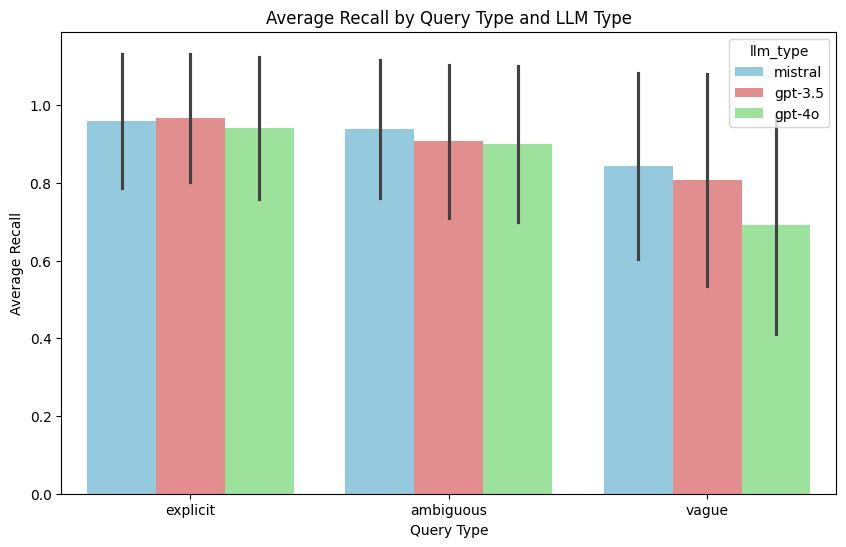

In [109]:
# Plot 1: Average recall for each query_type grouped by llm_type
plot_recall_by_query_type(results_df)

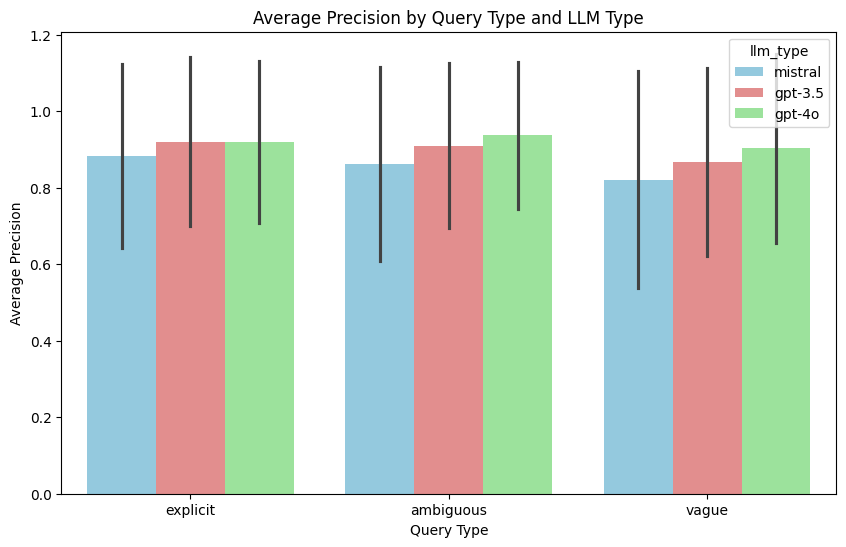

In [110]:
# Plot 2: Average precision for each query_type grouped by llm_type
plot_precision_by_query_type(results_df)

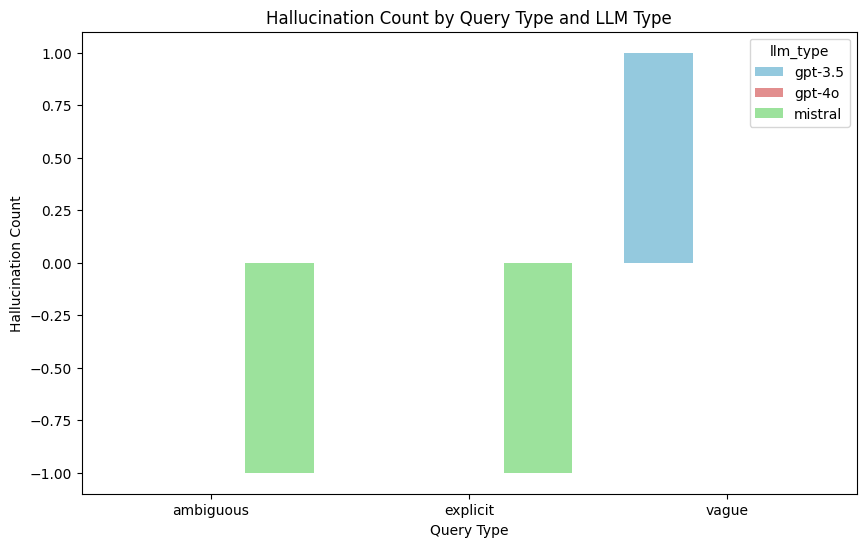

In [135]:
# Plot 3: Hallucination count for each query_type grouped by llm_type
plt.figure(figsize=(10, 6))
df_grouped = results_df.groupby(['query_type', 'llm_type'], as_index=False)['hallucination_count'].sum()

sns.barplot(x='query_type', y='hallucination_count', hue='llm_type', data=df_grouped, errorbar="sd", palette=colors)
plt.title('Hallucination Count by Query Type and LLM Type')
plt.ylabel('Hallucination Count')
plt.xlabel('Query Type')
plt.show()


# df_grouped = results_df.groupby(['query_type', 'llm_type'], as_index=False)['hallucination_count'].sum()

# # Create the bar plot
# plt.figure(figsize=(10, 6))
# sns.barplot(x='query_type', y='hallucination_count', hue='llm_type', data=df_grouped, palette=colors)

# # Customize plot labels and title
# plt.title('Hallucination Count by Query Type and LLM Type')
# plt.xlabel('Query Type')
# plt.ylabel('Total Hallucination Count')
# plt.xticks(rotation=45)

# # Show the plot
# plt.tight_layout()
# plt.show()

# # Group by species_type and shape_type, summing the counts
# grouped_df = results_df.groupby(['query_type', 'llm_type'], as_index=False)['hallucination_count'].sum()

# # Normalize counts for each species_type to range from 0 to 1
# grouped_df['normalized_count'] = grouped_df.groupby('query_type')['hallucination_count'].transform(lambda x: x / x.sum())

# # Create the plot
# plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped_df, x='query_type', y='normalized_count', hue='llm_type', palette=colors)

# # Adjust the y-axis to range from 0 to 1
# plt.ylim(0, 1)

# # Show the plot
# plt.show()


# data = {
#     'count': [10, 15, 20, 5, 10, 15, 7, 10, 12],
#     'species_type': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C'],
#     'shape_type': ['X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z']
# }
# df = pd.DataFrame(data)

# # Group by species_type and shape_type, summing the counts
# grouped_df = df.groupby(['species_type', 'shape_type'], as_index=False)['count'].sum()

# # Normalize counts for each species_type to range from 0 to 1
# grouped_df['normalized_count'] = grouped_df.groupby('species_type')['count'].transform(lambda x: x / x.sum())

# # Create the plot
# plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped_df, x='species_type', y='normalized_count', hue='shape_type')

# # Adjust the y-axis to range from 0 to 1
# plt.ylim(0, 1)

# # Show the plot
# plt.show()

## Experiment 2 Results

In [ ]:
# TODO

# OLD RESULTS: DO NOT RUN

In [ ]:
ground_truths_file = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths.json"

In [ ]:
def clean_scores(scores):
  cleaned_scores = []
  for item in scores:
    if '%' in item:
      cleaned = item.replace('%', '')
    else:
      cleaned = item

    cleaned_scores.append(float(cleaned))

  return cleaned_scores

In [ ]:
##############################################################################
# Plots the LLM-as-a-judge and computed accuracy scores accross the 3
# model types
##############################################################################

def plot_scores(llm_type, use_schema, naive=False):
  llm_acc_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_llm_eval_accuracies.json"
  calc_acc_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_calc_accuracies.json"
  llm_eval_times_outfile = "/content/drive/MyDrive/E6998-Project/" + RESULTS_DIR +"/"+ llm_type + "_schema_" + str(use_schema)+ "_naive_" + str(naive)+  "_eval_times.json"

  api_dict = {}

  with open(llm_acc_outfile, "r") as file:
    llm_acc = json.load(file)
    llm_eval_acc = [acc[0] for acc in llm_acc]

  with open(calc_acc_outfile, "r") as file:
    calc_acc = json.load(file)

  with open(llm_eval_times_outfile, "r") as file:
    eval_times = json.load(file)

  with open(ground_truths_file, "r") as file:
    ground_truths = json.load(file)

  print(llm_eval_acc)
  print(calc_acc)
  print(eval_times)

  cleaned_llm_eval_acc = clean_scores(llm_eval_acc)

  df = pd.DataFrame({'LLM-as-a-judge accuracy': cleaned_llm_eval_acc, 'Computed accuracy': calc_acc, 'Judging eval Time': eval_times})

  x_range = list(range(0, len(df)))
  y_range = [-5, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 5))
  plt.tight_layout()

  # plt.scatter(llm_eval_acc)
  sns.scatterplot(x=df.index, y=df['Computed accuracy'], marker='o', s=100, label='Computed accuracy', color='C0')

  # Plot col2 with x marker and smaller size
  sns.scatterplot(x=df.index, y=df['LLM-as-a-judge accuracy'], marker='x', s=200, label='LLM-as-a-judge accuracy', color='red')

  plt.xticks(x_range)
  plt.yticks(y_range)
  plt.xlim(-1, len(calc_acc))
  plt.ylim(0, 105)
  # sns.lineplot(data=eval_times, x="Batch Size", y="Throughput", marker="o")
  plt.title(llm_type+ "-as-a-Judge Accuracy vs. Computed Accuracy")
  plt.xlabel("API Run #")
  plt.ylabel("Accuracies")
  plt.legend(loc='lower center')

  plt.show()

  return df


In [ ]:
##############################################################################
# Calculates the % of matched scores between the LLM-as-a-judge accuracy and
# the computed accuracy between each model type.
##############################################################################

def calculate_match_percentage(df):
  """Calculates the percentage of times LLM and computed accuracy match."""
  return (df['LLM-as-a-judge accuracy'] == df['Computed accuracy']).mean() * 100

def calculate_precent_match(mistral_df, gpt3_df, gpt4_df):
  # Calculate percentages
  mistral_percentage = calculate_match_percentage(mistral_df)
  gpt3_5_percentage = calculate_match_percentage(gpt3_df)
  gpt4_percentage = calculate_match_percentage(gpt4_df)

  # Create a bar chart
  models = ['Mistral', 'GPT-3.5', 'GPT-4']
  percentages = [mistral_percentage, gpt3_5_percentage, gpt4_percentage]
  colors = ['skyblue', 'lightcoral', 'lightgreen']

  plt.figure(figsize=(8, 6))
  plt.bar(models, percentages, color=colors)
  plt.xlabel('LLM Model')
  plt.ylabel('Match Percentage (%)')
  plt.title('Percentage of Matching LLM-as-a-judge Accuracy and Computed Accuracy Scores')
  plt.ylim(0, 100) # Set y-axis limit

  for i, v in enumerate(percentages):
      plt.text(i, v + 2, str(round(v, 2)) + '%', ha='center') # Add percentage labels


  plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

##############################################################################
# Counts the number of ground truth optional and required parameters as well as
# the number of LLM-generated optional and required parameters for
# comparison
##############################################################################

def avg_acc_plot(mistral_df, gpt3_df, gpt4_df):

  dfs = [mistral_df, gpt3_df, gpt4_df]
  df_names = ['Mistral', 'GPT-3.5', 'GPT-4o']
  colors = ['skyblue', 'lightcoral', 'lightgreen']

  avg_computed_accuracy = [df['Computed accuracy'].mean() for df in dfs]
  rounded_avg_computed_accuracy = [round(num, 2) for num in avg_computed_accuracy]

  avg_llm_accuracy = [df['LLM-as-a-judge accuracy'].mean() for df in dfs]
  rounded_avg_llm_accuracy = [round(num, 2) for num in avg_llm_accuracy]

  y_range = [0, 5, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  ax = sns.barplot(x=df_names, y=rounded_avg_computed_accuracy, palette=colors)
  plt.title('Average Computed Accuracy')
  plt.ylabel('Average Accuracy')
  plt.yticks(y_range)
  for container in ax.containers:
      ax.bar_label(container)

  plt.subplot(1, 2, 2)
  ax = sns.barplot(x=df_names, y=rounded_avg_llm_accuracy, palette=colors)
  plt.title('Average LLM-as-a-judge Accuracy')
  plt.ylabel('Average Accuracy')
  plt.yticks(y_range)
  for container in ax.containers:
      ax.bar_label(container)
  plt.tight_layout()
  plt.show()

In [ ]:
##############################################################################
# Counts the number of ground truth optional and required parameters as well as
# the number of LLM-generated optional and required parameters for
# comparison
##############################################################################

def get_params_counts(llm_response_file, llm_type):
  with open(ground_truths_file, "r") as file:
    ground_truths = json.load(file)

  with open(llm_response_file, "r") as file:
    llm_responses = json.load(file)

  with open(specs_dict, "r") as file:
    api_specs = json.load(file)

  llm_accuracies = []
  calc_accuracies = []
  eval_times = []

  gt_req_params_count = 0
  gt_opt_params_count = 0
  llm_req_params_count = 0
  llm_opt_params_count = 0

  for idx, (gt_obj, llm_params) in enumerate(zip(ground_truths, llm_responses)):
    if type(llm_params) == str:
      try:
          llm_params = json.loads(llm_params)
      except json.JSONDecodeError:
          # Attempt to fix common JSON errors, like single quotes
          llm_params = llm_params.replace("'", '"')  # Replace single quotes with double quotes
          try:
              llm_params = json.loads(llm_params)
          except json.JSONDecodeError as e:
              print(f"Error parsing JSON for item {idx}: {e}")
              print(f"Original string: {llm_params}")
              # Handle the error, e.g., skip this item or set a default value
              continue
    # llm_params_obj = json.loads(llm_params)
    llm_param_keys = set(llm_params.keys())
    api_name = gt_obj.get("name", "")
    spec = api_specs[api_name]

    gt_params = gt_obj.get("query_parameters", {})
    gt_params_keys = set(gt_params.keys())

    required_keys = set([k for k, v in spec["query_parameters"].items() if v["required"]])
    optional_keys = set([k for k, v in spec["query_parameters"].items() if not v["required"]])

    gt_required_params = required_keys.intersection(gt_params_keys)
    gt_req_params_count += len(gt_required_params)

    gt_optional_params = optional_keys.intersection(gt_params_keys)
    gt_opt_params_count += len(gt_optional_params)

    llm_required_correct = required_keys.intersection(llm_param_keys)
    # print("Correctly detected required keys", llm_required_correct)
    llm_req_params_count += len(llm_required_correct)

    llm_optional_correct = optional_keys.intersection(llm_param_keys)
    # print("Correctly detected optional keys", llm_optional_correct)
    llm_opt_params_count += len(llm_optional_correct)

  df = pd.DataFrame({
      'GT Required Params': [gt_req_params_count],
      'LLM Generated Required Params': [llm_req_params_count],
      'GT Optional Params': [gt_opt_params_count],
      'LLM Generated Optional Params':[llm_opt_params_count]
      })

  return df


In [ ]:
##############################################################################
# Plots the number of ground truth optional and required parameters as well as
# the number of LLM-generated optional and required parameters for
# comparison
##############################################################################
def params_count_plot(mistral, gpt3, gpt4):
  dfs = [mistral, gpt3, gpt4]
  df_names = ['Mistral', 'GPT-3.5', 'GPT-4o']

  # Create a list to store the modified dataframes
  modified_dfs = []

  # Iterate through the dataframes and modify them
  for i, df in enumerate(dfs):
    # Add a new column to identify the source dataframe
    df['Model Type'] = df_names[i]
    modified_dfs.append(df)

  # Concatenate the modified dataframes
  combined_df = pd.concat(modified_dfs, ignore_index=True)

  # Set the 'Source' column as the index
  combined_df = combined_df.set_index('Model Type')

  # Plotting the combined DataFrame
  # plt.figure(figsize=(16, 10))
  fig, axs = plt.subplots(1, 2, figsize=(15, 7))


  # First barchart: All 3 rows, first 2 columns
  cols_first_plot = combined_df.columns[:2]
  combined_df[cols_first_plot].plot(kind='bar', rot=0, ax=axs[0])  # Using combined_df with only the first 2 columns
  axs[0].set_title('Total Required Parameters for Ground Truth vs. LLM-generated parameters')
  axs[0].set_ylabel('Number of Required Parameters')
  axs[0].legend(loc='lower right')

  # Second barchart: All 3 rows, last 2 columns
  cols_second_plot = combined_df.columns[2:]
  combined_df[cols_second_plot].plot(kind='bar', rot=0, ax=axs[1])  # Using combined_df with only the last 2 columns
  axs[1].set_title('Total Optional Parameters for Ground Truth vs. LLM-generated parameters')
  axs[1].set_ylabel('Number of Optional Parameters')
  axs[1].legend(loc='lower right')

  plt.tight_layout()
  plt.show()


## With Schema

Below are the plots for LLM-generated results computed using a full version of the API schema (i.e. LLM has knowledge of parameter names, descriptions, whether they're required or not).


['100', '86.0', '68', '50.0', '38.0', '88.33', '53.33', '90.0', '85', '100', '50.0', '100', '100', '100', '66.7', '100', '65.0', '65.0', '65.0', '65.0', '100', '100', '100', '65.0', '30.0']
[100.0, 86.0, 68.0, 100.0, 80.0, 88.33333333333333, 53.333333333333336, 90.0, 85.0, 100.0, 100.0, 100.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 65.0, 65.0, 65.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.5912668704986572, 16.00346803665161, 10.911358833312988, 10.596814155578613, 13.937248468399048, 17.866000413894653, 12.090967655181885, 9.30030632019043, 5.376952648162842, 11.755417823791504, 14.732611894607544, 10.554229259490967, 7.4871485233306885, 16.226848363876343, 13.157913446426392, 0.973757266998291, 12.958509922027588, 9.054942607879639, 12.384786128997803, 14.382687330245972, 7.5032877922058105, 10.57797908782959, 0.5254917144775391, 8.878979921340942, 8.829626560211182]


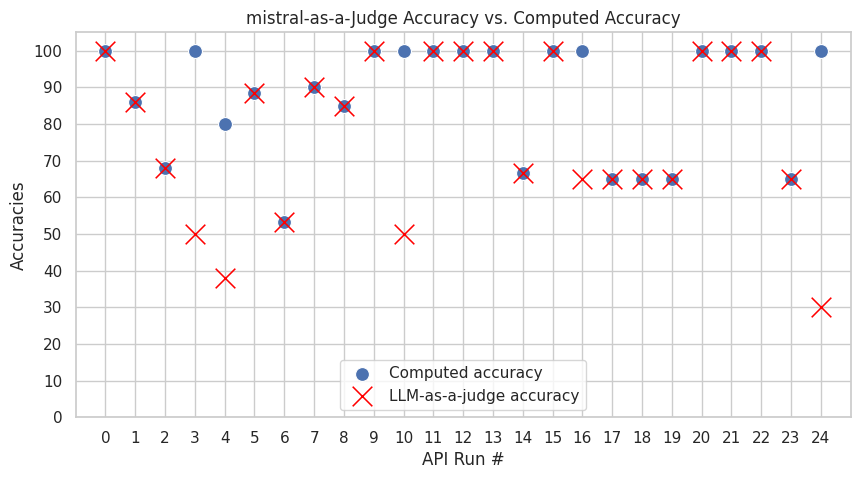

In [ ]:
RESULTS_DIR = "results12172024"
mistral_schema_true_df = plot_scores("mistral", True, False)

['76.67', '0', '74', '100', '44', '38.33', '36.67', '76.9', '100', '65', '75', '76.67', '100', '100', '66.7', '66.7', '100', '65', '70', '50', '100', '100', '100', '100', '100']
[76.66666666666667, 72.0, 40.0, 100.0, 72.0, 83.33333333333334, 100.0, 76.66666666666667, 100.0, 100.0, 82.5, 76.66666666666667, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 65.0, 70.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[1.3661212921142578, 1.9166250228881836, 1.653421401977539, 0.884667158126831, 1.4868202209472656, 1.762237787246704, 4.657472610473633, 2.1232545375823975, 0.794609785079956, 1.815938949584961, 2.2956666946411133, 1.4132494926452637, 1.4639472961425781, 1.619420051574707, 1.8490204811096191, 3.816237211227417, 0.7102909088134766, 1.405022144317627, 1.4297761917114258, 1.5250799655914307, 0.8503882884979248, 0.722022294998169, 0.7007360458374023, 0.8782045841217041, 0.9389300346374512]


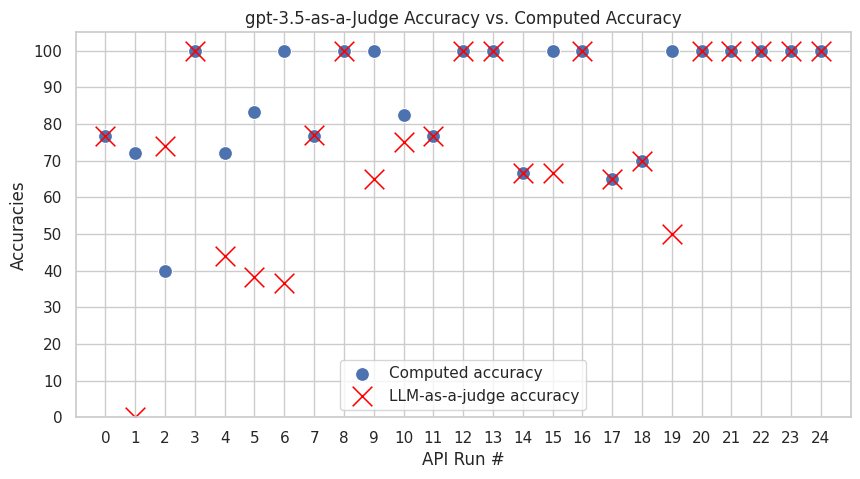

In [ ]:
RESULTS_DIR = "results12172024"

gpt3_5_schema_true_df = plot_scores("gpt-3.5", True, False)

['100', '86', '68.0', '100', '80.0', '88.33', '66.67', '90.0', '50.0', '100', '100.0', '100', '76.67', '100', '66.7', '100', '100', '65.0', '65.0', '65.0', '100', '100', '100', '65.0', '0.0']
[100.0, 86.0, 68.0, 100.0, 80.0, 88.33333333333333, 100.0, 90.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 65.0, 65.0, 65.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.49387335777282715, 5.125124454498291, 8.175331592559814, 3.7230796813964844, 5.781414031982422, 7.561198949813843, 10.662944078445435, 6.9673309326171875, 5.4196906089782715, 8.593205451965332, 5.084602117538452, 6.466555595397949, 10.201228380203247, 6.902551651000977, 6.872558355331421, 1.5917460918426514, 6.288180589675903, 5.043889045715332, 6.459248065948486, 6.054797172546387, 0.5618493556976318, 0.7699310779571533, 0.5311405658721924, 8.714313745498657, 8.18622636795044]


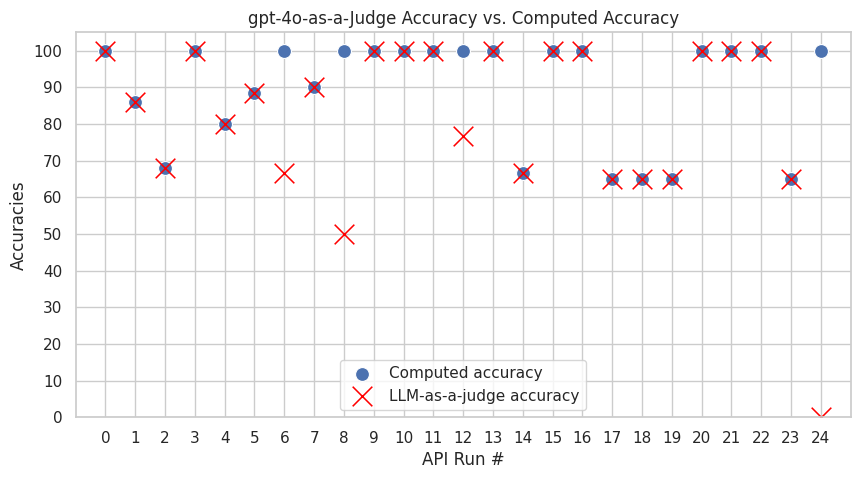

In [ ]:
RESULTS_DIR = "results12172024"
gpt4o_schema_true_df = plot_scores("gpt-4o", True, False)

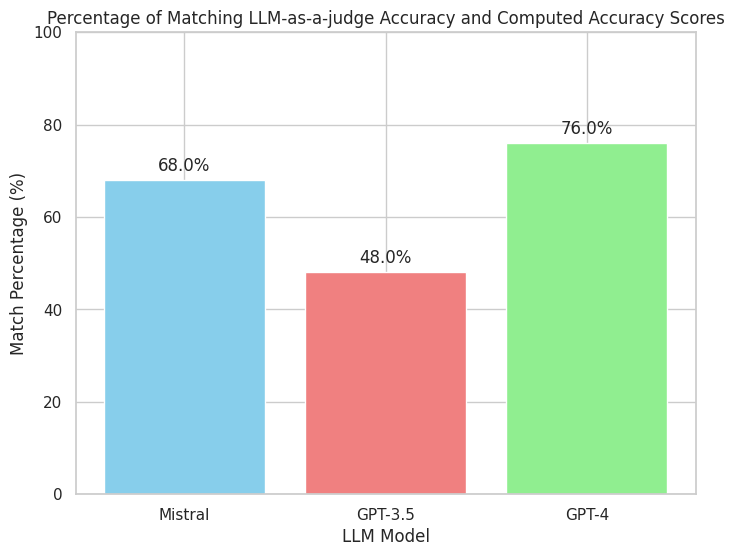

In [ ]:
calculate_precent_match(mistral_schema_true_df, gpt3_5_schema_true_df, gpt4o_schema_true_df)

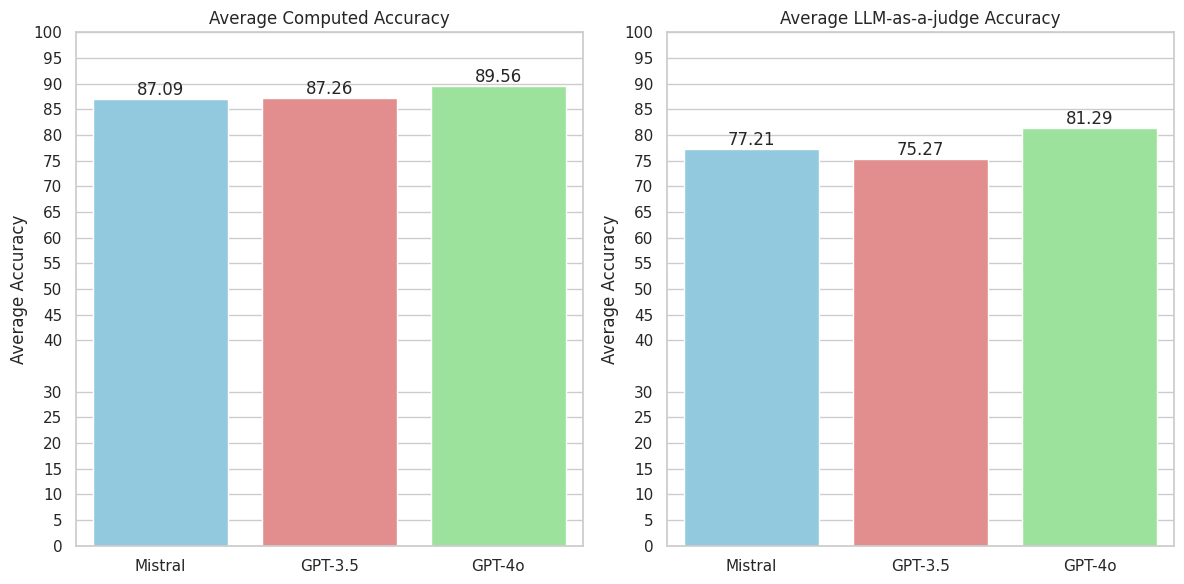

In [ ]:
avg_acc_plot(mistral_schema_true_df, gpt3_5_schema_true_df, gpt4o_schema_true_df)

In [ ]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results/mistral_schema_True_llm_responses.json"

mistral_params_count = get_params_counts(llm_response_file, "mistral")
mistral_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,34,43,36


In [ ]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results/gpt-3.5_schema_True_llm_responses.json"

gpt3_params_count = get_params_counts(llm_response_file, "gpt-3.5")
gpt3_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,34,43,32


In [ ]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results/gpt-4o_schema_True_llm_responses.json"

gpt4_params_count = get_params_counts(llm_response_file, "gpt-4o")
gpt4_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,34,43,37


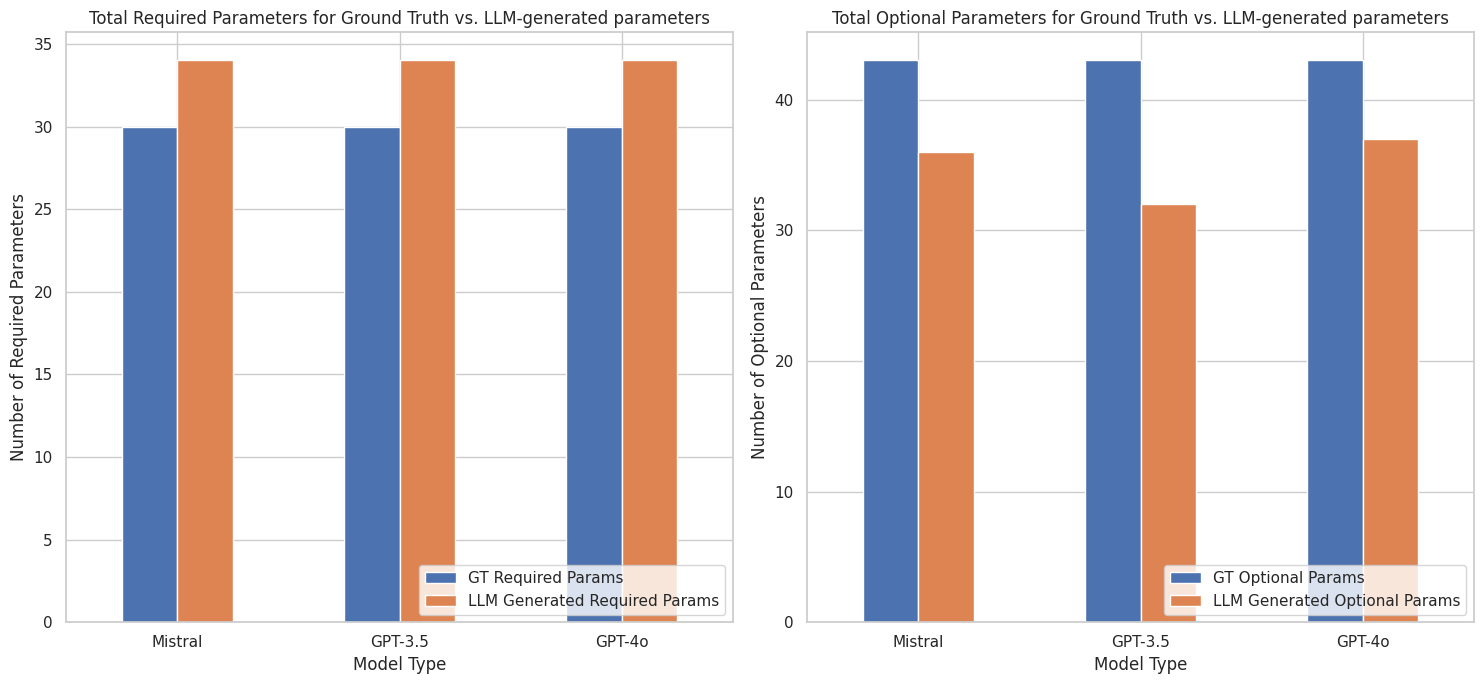

In [ ]:
params_count_plot(mistral_params_count, gpt3_params_count, gpt4_params_count)

## With Naive Schema
Below are the plots for LLM-generated results computed using a naive version of the API schema (i.e. LLM has knowledge of parameter names but not whether they are optional or required).


['100', '80.0', '74.0', '50.0', '94.0', '100', '76.67', '90.0', '50.0', '100', '100', '90.0', '100', '100', '66.67', '100', '65.0', '100', '50.0', '65.0', '100', '100', '100', '65.0', '100']
[100.0, 80.0, 34.000000000000014, 100.0, 94.0, 100.0, 76.66666666666667, 90.0, 50.0, 100.0, 100.0, 90.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 100.0, 100.0, 65.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.692293643951416, 1.2934439182281494, 1.2853751182556152, 0.8682835102081299, 1.4343817234039307, 2.115389347076416, 0.7518606185913086, 1.1459403038024902, 0.9845051765441895, 1.1995031833648682, 1.318422794342041, 1.2652945518493652, 1.125394344329834, 1.1295950412750244, 1.072558879852295, 0.93304443359375, 0.8347854614257812, 1.1865801811218262, 0.93086838722229, 0.7436707019805908, 0.8663997650146484, 0.8321435451507568, 0.978646993637085, 1.570605754852295, 1.1519837379455566]


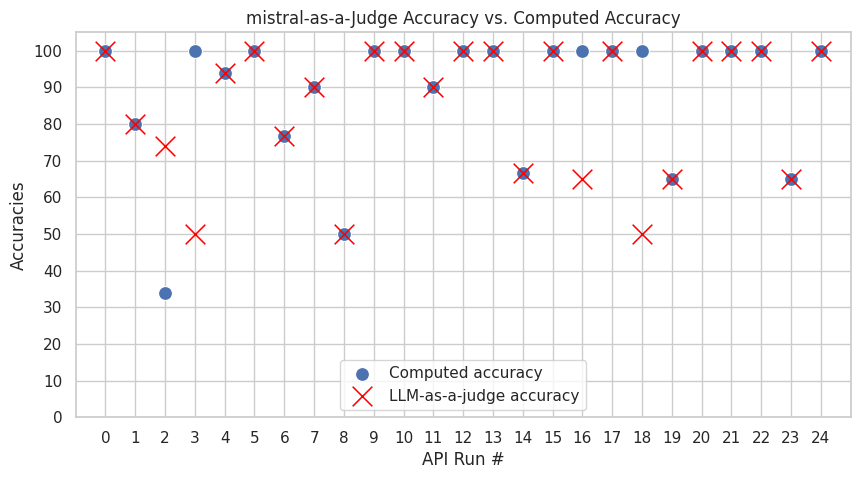

In [ ]:
RESULTS_DIR = "results_naive12172024"

mistral_schema_naive_df = plot_scores("mistral", True, True)

['76.9', '94', '48', '85', '86', '33.33', '76.67', '76.9', '50', '100', '82.5', '76.9', '100', '100', '67', '100', '100', '100', '100%', '65', '100', '100', '100', '100', '100']
[76.66666666666667, 94.0, 70.0, 100.0, 86.0, 100.0, 100.0, 76.66666666666667, 50.0, 100.0, 82.5, 76.66666666666667, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[0.5967414379119873, 0.8249213695526123, 1.203988790512085, 0.5232391357421875, 0.9028103351593018, 0.919175386428833, 0.7564449310302734, 0.7054235935211182, 0.6736721992492676, 0.7706007957458496, 0.8137030601501465, 0.7539613246917725, 1.1628482341766357, 0.80859375, 0.8070371150970459, 0.6502516269683838, 0.7670392990112305, 0.7135958671569824, 0.8657145500183105, 0.6310746669769287, 0.7448394298553467, 0.5586562156677246, 0.6713578701019287, 1.1778512001037598, 0.6766092777252197]


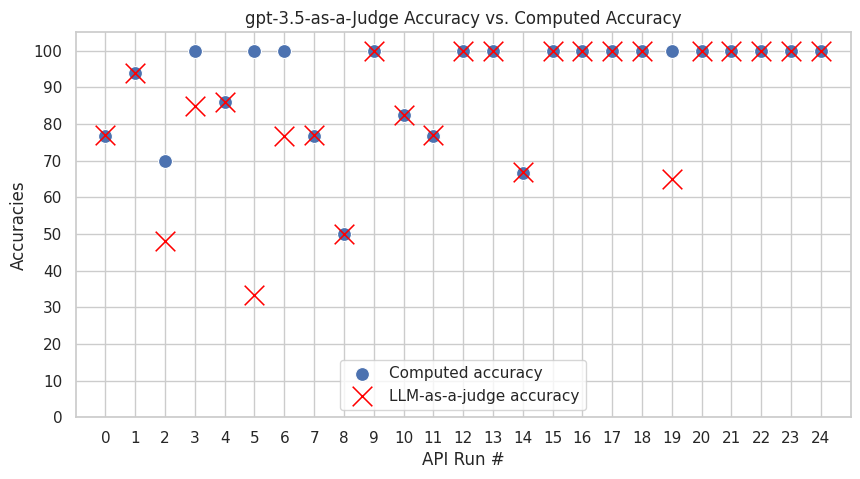

In [ ]:
RESULTS_DIR = "results_naive12172024"

gpt3_schema_naive_df = plot_scores("gpt-3.5", True, True)

['100', '80.0', '86.0', '100', '80.0', '53.33', '80.0', '70.0', '65.0', '100', '85.0', '100', '100', '100', '66.67', '100', '100', '100', '65.0', '100', '100', '100', '100', '65.0', '100']
[100.0, 80.0, 86.0, 100.0, 80.0, 88.33333333333333, 100.0, 70.0, 65.0, 100.0, 100.0, 100.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.7708530426025391, 1.0067167282104492, 1.0048727989196777, 0.9711997509002686, 1.3863420486450195, 1.1375963687896729, 1.2515263557434082, 2.175271511077881, 0.5638678073883057, 1.3125455379486084, 1.5649464130401611, 0.8082869052886963, 1.1351706981658936, 1.0760788917541504, 1.1390228271484375, 0.7497899532318115, 1.5991570949554443, 0.8197948932647705, 0.8898868560791016, 1.0693790912628174, 0.6209700107574463, 0.8619956970214844, 0.8659250736236572, 0.8583252429962158, 0.8056900501251221]


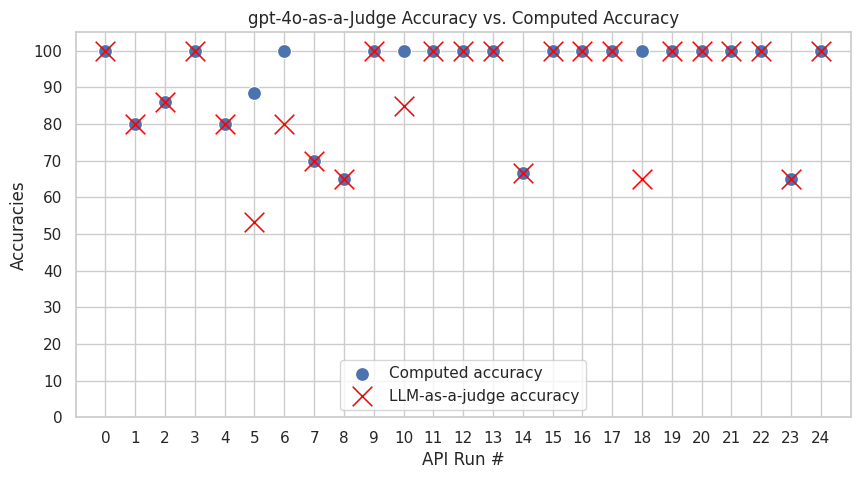

In [ ]:
RESULTS_DIR = "results_naive12172024"

gpt4_schema_naive_df = plot_scores("gpt-4o", True, True)

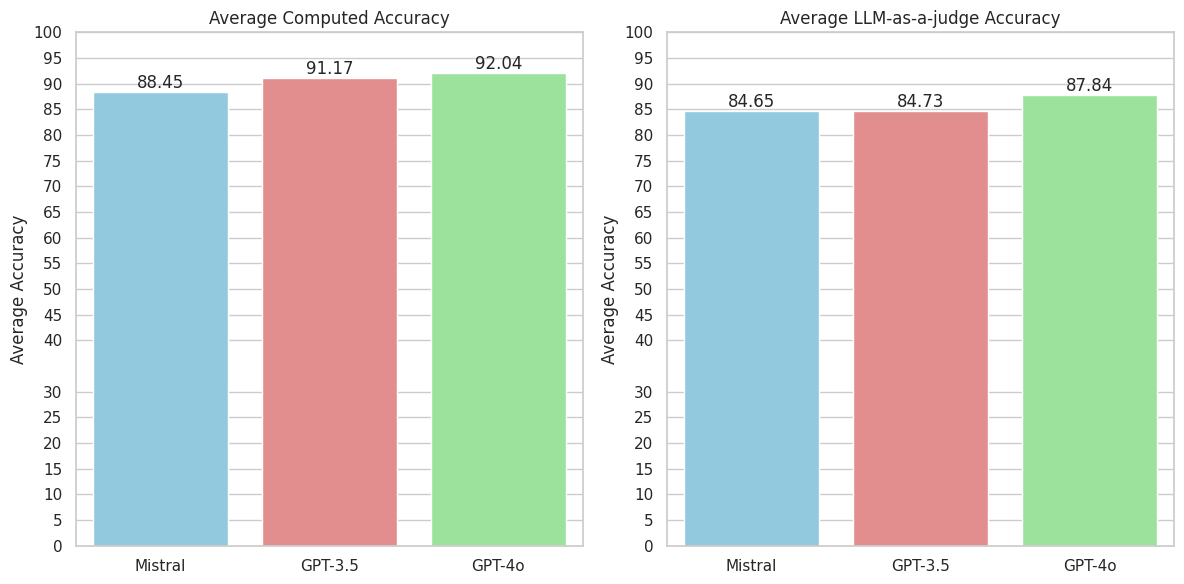

In [ ]:
avg_acc_plot(mistral_schema_naive_df, gpt3_schema_naive_df, gpt4_schema_naive_df)

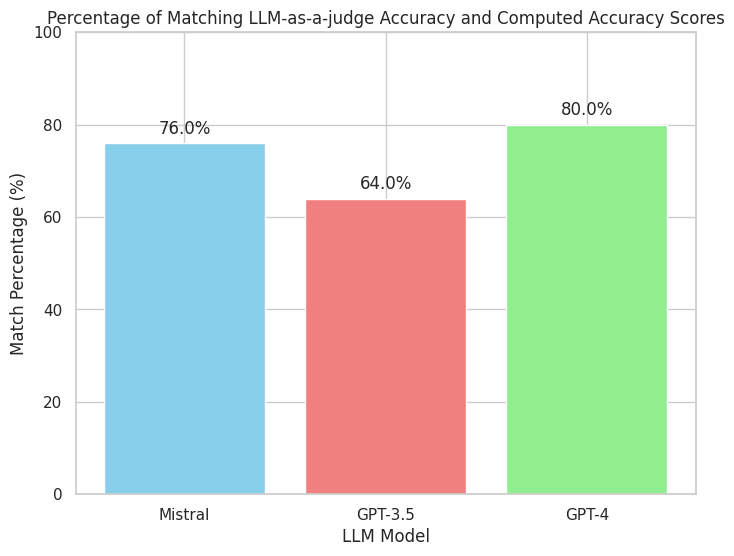

In [ ]:
calculate_precent_match(mistral_schema_naive_df, gpt3_schema_naive_df, gpt4_schema_naive_df)

In [ ]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results_naive12172024/mistral_schema_True_naive_True_llm_responses.json"

mistral_params_count = get_params_counts(llm_response_file, "mistral")
mistral_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,32,43,43


In [ ]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results_naive12172024/gpt-3.5_schema_True_naive_True_llm_responses.json"

gpt3_params_count = get_params_counts(llm_response_file, "gpt-3.5")
gpt3_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,31,43,44


In [ ]:
llm_response_file = "/content/drive/MyDrive/E6998-Project/results_naive12172024/gpt-4o_schema_True_naive_True_llm_responses.json"

gpt4_params_count = get_params_counts(llm_response_file, "gpt-4o")
gpt4_params_count

,GT Required Params,LLM Generated Required Params,GT Optional Params,LLM Generated Optional Params
0,30,30,43,43


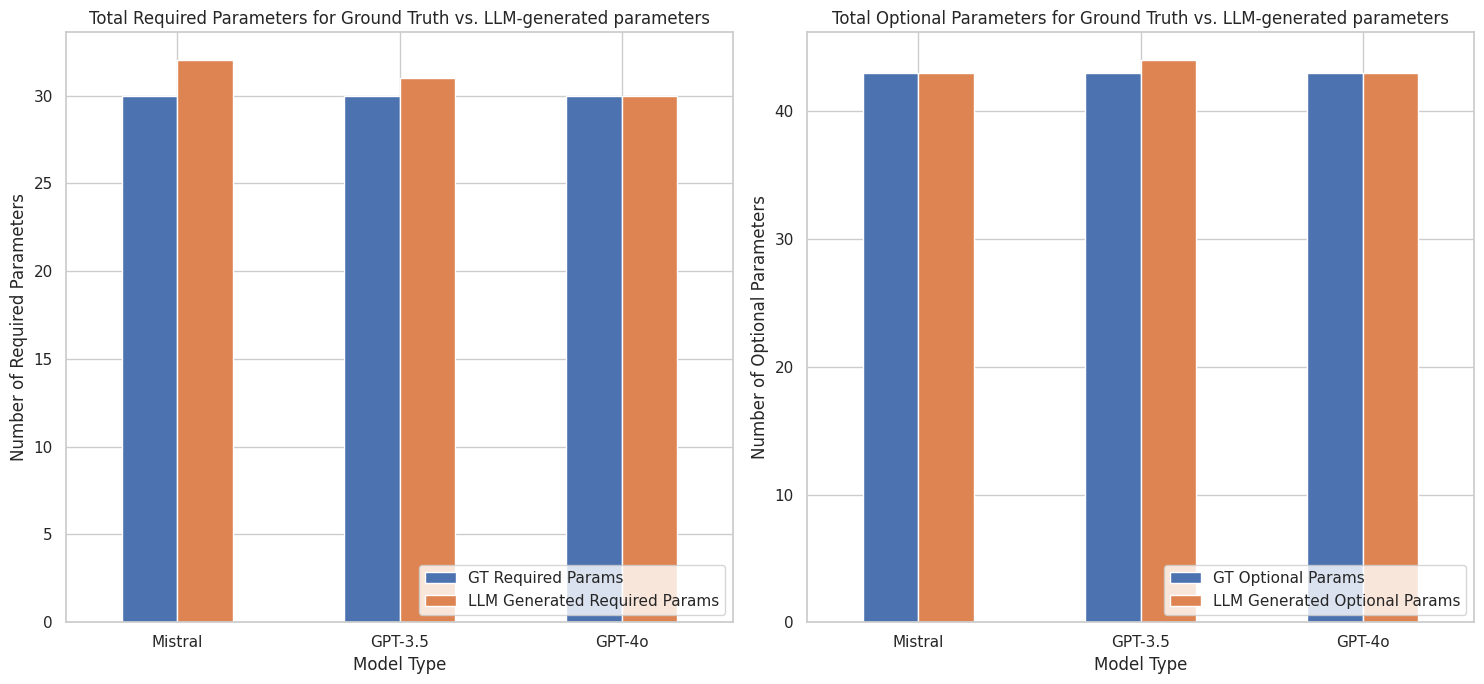

In [ ]:
params_count_plot(mistral_params_count, gpt3_params_count, gpt4_params_count)

## Without Spec

Below are the plots for LLM-generated results computed without using any version of the API schema or naive API schema.



['100', '62', '74.0', '100', '86.0', '88.33', '100', '100', '100', '100', '82.5', '70.0', '100', '100', '100', '76.69', '100', '50.0', '50.0', '65.0', '100', '100', '100', '65.0', '100']
[100.0, 14.000000000000014, 34.000000000000014, 50.0, 66.0, 71.66666666666667, 33.33333333333334, 33.33333333333334, 0.0, 0.0, 32.5, -29.99999999999997, 100.0, 66.66666666666667, 100.0, 76.66666666666667, 0.0, 50.0, 50.0, 15.0, 0.0, 0.0, 0.0, 15.0, 0.0]
[0.8249602317810059, 1.4174461364746094, 1.5890448093414307, 0.7419719696044922, 1.3625431060791016, 1.5719218254089355, 0.9721271991729736, 0.838188886642456, 0.7900278568267822, 0.9199697971343994, 0.8153150081634521, 1.2062201499938965, 2.3054802417755127, 1.670513391494751, 1.3855502605438232, 0.6655068397521973, 0.9309585094451904, 1.2152988910675049, 2.142643690109253, 0.9598267078399658, 0.8948726654052734, 1.4055912494659424, 1.1431169509887695, 0.6806683540344238, 0.8722760677337646]


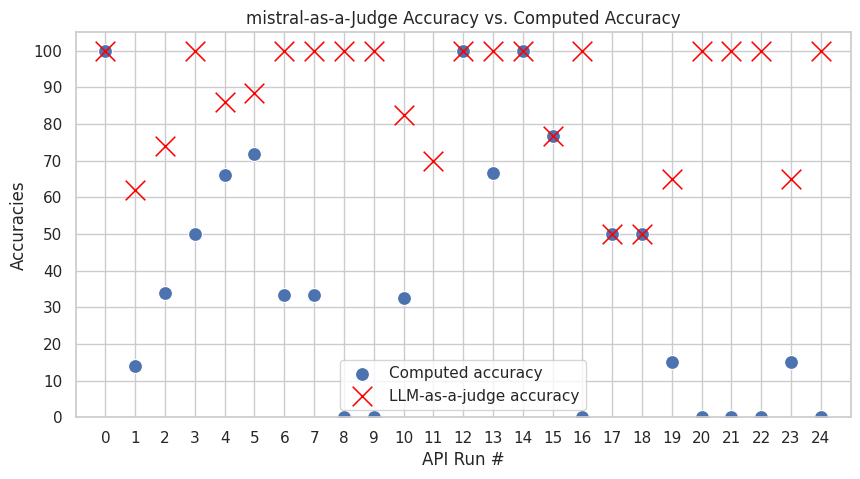

In [ ]:
RESULTS_DIR = "results_noschema12172024"

mistral_schema_naive_false_df = plot_scores("mistral", False, False)

['76.9', '20', '46', '65', '72', '55', '100', '43.33', '0', '0', '67.5', '66.67', '100', '100', '76.67', '76.7', '50', '100', '100', '65', '100', '100', '50', '15', '100%']
[76.66666666666667, 14.000000000000014, 6.0, 15.0, 12.000000000000014, 26.666666666666657, 0.0, 13.333333333333343, 0.0, 0.0, 32.5, 10.000000000000014, 66.66666666666667, 100.0, 76.66666666666667, 76.66666666666667, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 15.0, 15.0, 0.0]
[0.7572410106658936, 1.4652352333068848, 0.8172245025634766, 0.7173655033111572, 0.8638255596160889, 0.8684201240539551, 1.262864112854004, 0.8033344745635986, 0.7815310955047607, 0.6467587947845459, 0.7502927780151367, 0.7225058078765869, 0.6841592788696289, 0.7260406017303467, 0.6394064426422119, 0.686107873916626, 0.8262450695037842, 0.6823816299438477, 0.718900203704834, 0.5992372035980225, 0.6428029537200928, 0.6606059074401855, 0.7166540622711182, 0.647740364074707, 0.7024552822113037]


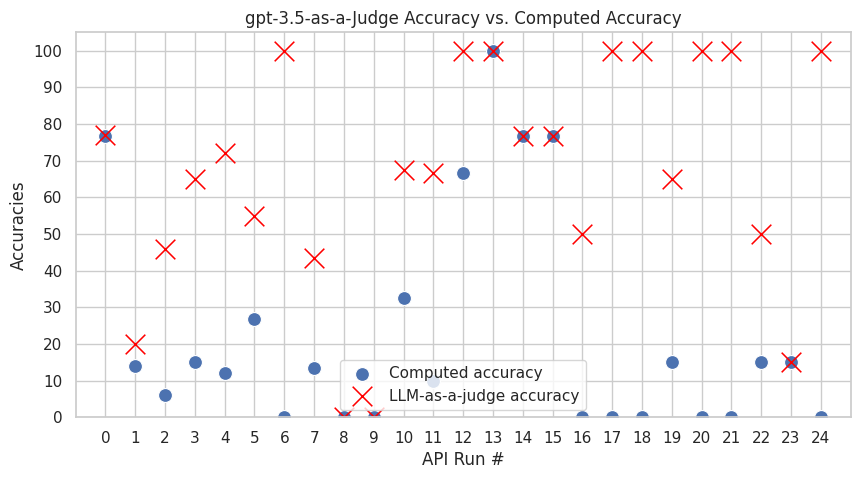

In [ ]:
RESULTS_DIR = "results_noschema12172024"

gpt3_schema_naive_false_df = plot_scores("gpt-3.5", False, False)

['100', '74.0', '86.0', '100', '86.0', '48.3', '76.69', '66.7', '65.0', '100', '100', '100', '100', '100', '100', '53.33', '50.0', '65.0', '65.0', '65.0', '100', '100', '65.0', '65.0', '100']
[100.0, 14.000000000000014, 46.0, 0.0, 66.0, 38.33333333333334, 43.333333333333336, 33.33333333333334, 15.0, 0.0, 25.000000000000014, 0.0, 100.0, 66.66666666666667, 100.0, 53.333333333333336, 0.0, 15.0, 15.0, 15.0, 0.0, 0.0, 15.0, 15.0, 0.0]
[2.0485222339630127, 1.372227668762207, 0.8318772315979004, 0.7402212619781494, 2.7615091800689697, 1.2295024394989014, 0.7259526252746582, 0.9488756656646729, 0.6491925716400146, 0.8514566421508789, 1.0630028247833252, 0.902961015701294, 0.7315540313720703, 1.0029091835021973, 1.0739445686340332, 0.833549976348877, 1.2481520175933838, 0.9638917446136475, 0.8633568286895752, 0.9493250846862793, 0.8723134994506836, 0.8130753040313721, 0.7069227695465088, 0.8004100322723389, 1.1313304901123047]


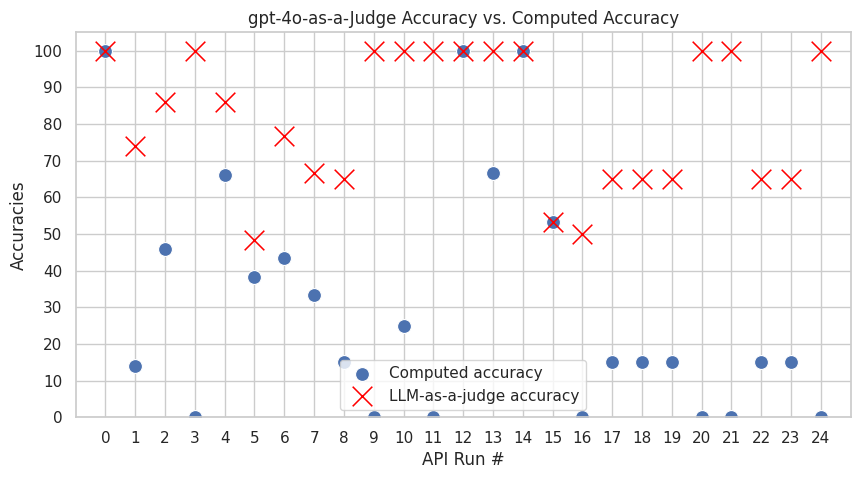

In [ ]:
RESULTS_DIR = "results_noschema12172024"

gpt4_schema_naive_false_df = plot_scores("gpt-4o", False, False)

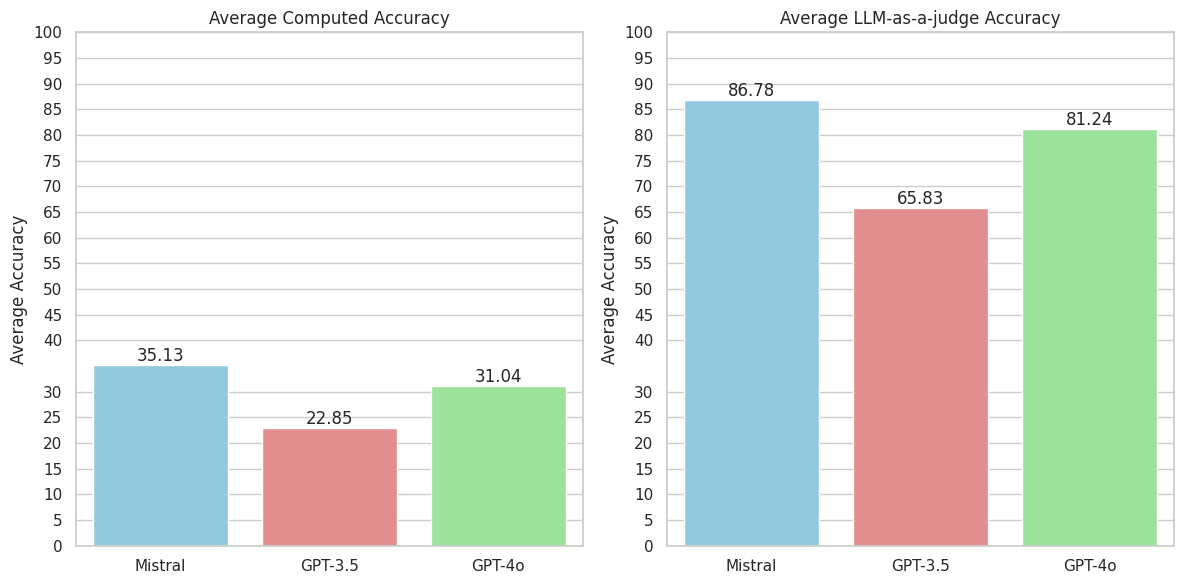

In [ ]:
avg_acc_plot(mistral_schema_naive_false_df, gpt3_schema_naive_false_df, gpt4_schema_naive_false_df)

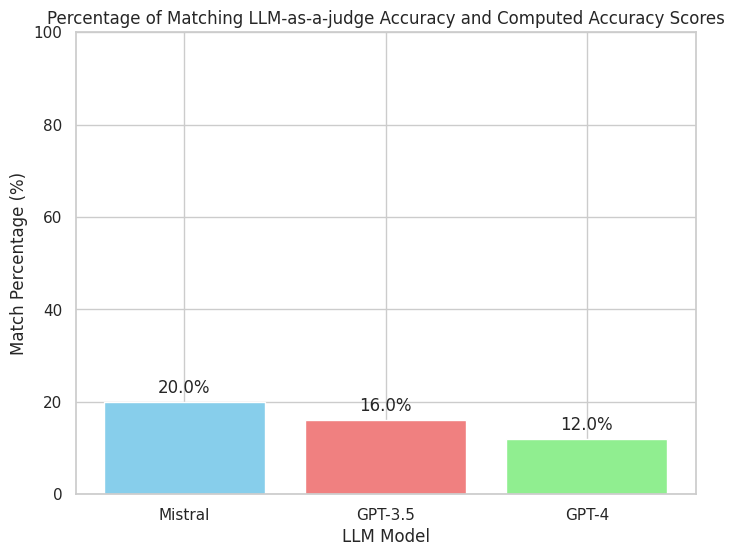

In [ ]:
calculate_precent_match(mistral_schema_naive_false_df, gpt3_schema_naive_false_df, gpt4_schema_naive_false_df)

# Earlier Examples


---



## Example 1

In [ ]:
make_api_call({
            "ticker": "msft",
            "formtype": "10-q",
            "filingorder": "10"
        }, "https://last10k-company-v1.p.rapidapi.com/v1/company/balancesheet","last10k-company-v1.p.rapidapi.com")

host  last10k-company-v1.p.rapidapi.com  response code  200


({'meta': {'copyright': 'Copyright 2024 Last10K.com All Rights Reserverd',
   'terms': ['https://dev.last10k.com/terms',
    'https://www.sec.gov/privacy.htm#security']},
  'data': {'attributes': {'status': 0,
    'company': {'name': 'MICROSOFT CORP', 'cik': '789019', 'ticker': 'msft'},
    'filing': {'name': 'Balance Sheets',
     'accessionNumber': '0001564590-21-020891',
     'filingDate': '2021-04-27T00:00:00',
     'period': '2021-03-31T00:00:00',
     'formType': '10-Q',
     'filingCount': 0},
    'count': 33,
    'result': {'CashAndCashEquivalentsAtCarryingValue': 13702000000.0,
     'ShortTermInvestments': 111705000000.0,
     'CashCashEquivalentsAndShortTermInvestments': 125407000000.0,
     'AccountsReceivableNetCurrent': 26322000000.0,
     'InventoryNet': 2245000000.0,
     'OtherAssetsCurrent': 11640000000.0,
     'AssetsCurrent': 165614000000.0,
     'PropertyPlantAndEquipmentNet': 54945000000.0,
     'OperatingLeaseRightOfUseAsset': 10673000000.0,
     'LongTermInvestme

In [ ]:
query_string = {"q":"London","days":"1","aqi":"yes"}
api_url = "https://weatherapi-com.p.rapidapi.com/forecast.json"
host = "weatherapi-com.p.rapidapi.com"

all_weather_params = {
    "q" : "required",
    "days" : "required",
    "hour" : "optional",
    "aqi" : "optional",
    "tp" : "optional",
    "lang" : "optional",
}


In [ ]:
ground_truth_res, ground_truth_params = make_api_call(query_string, api_url, host)

In [ ]:
json_print(ground_truth_res)

{
  "location": {
    "name": "London",
    "region": "City of London, Greater London",
    "country": "United Kingdom",
    "lat": 51.5171,
    "lon": -0.1062,
    "tz_id": "Europe/London",
    "localtime_epoch": 1734077583,
    "localtime": "2024-12-13 08:13"
  },
  "current": {
    "last_updated_epoch": 1734076800,
    "last_updated": "2024-12-13 08:00",
    "temp_c": 6.0,
    "temp_f": 42.8,
    "is_day": 1,
    "condition": {
      "text": "Light rain",
      "icon": "//cdn.weatherapi.com/weather/64x64/day/296.png",
      "code": 1183
    },
    "wind_mph": 3.4,
    "wind_kph": 5.4,
    "wind_degree": 108,
    "wind_dir": "ESE",
    "pressure_mb": 1026.0,
    "pressure_in": 30.3,
    "precip_mm": 0.03,
    "precip_in": 0.0,
    "humidity": 100,
    "cloud": 50,
    "feelslike_c": 5.1,
    "feelslike_f": 41.1,
    "windchill_c": 5.5,
    "windchill_f": 41.9,
    "heatindex_c": 6.4,
    "heatindex_f": 43.5,
    "dewpoint_c": 3.2,
    "dewpoint_f": 37.8,
    "vis_km": 4.5,
    "vis_m

In [ ]:
api_endpoint = "https://weatherapi-com.p.rapidapi.com/forecast.json"
api_query = "What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality"
mistral_generated_response = make_llm_api_call(api_endpoint, api_query, "mistral", {}, "")

DEBUG: ```json
{
  "q": "London",
  "days": "1",
  "aqi": "yes"
}
```
DEBUG: {
  "q": "London",
  "days": "1",
  "aqi": "yes"
}



In [ ]:
mistral_generated_response

{'q': 'London', 'days': '1', 'aqi': 'yes'}

In [ ]:
chatgpt_generated_response = make_llm_api_call(api_endpoint, api_query, "openai", {}, "")

DEBUG: {
    "query": "London",
    "day": "today"
}


In [ ]:
chatgpt_generated_response

'{\n    "query": "London",\n    "day": "today"\n}'

In [ ]:
evaluation_result = evaluate_responses(ground_truth_params, mistral_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: The two responses are identical, so the accuracy score is 100%. 
Justification: Both responses have the same query parameters ('q', 'days', 'aqi') with the same values, so the accuracy score is maximum.


In [ ]:
evaluation_result = evaluate_responses(ground_truth_params, chatgpt_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: The ground truth response has 3 parameters: 'q', 'days', and 'aqi'.
The generated response has 2 parameters: 'query' and 'day'.

Calculating the accuracy:
- Parameters in ground truth but not in generated response: 1 ('days')
- Parameters in generated response but not in ground truth: 2 ('query', 'day')

Accuracy = 100 - [100 * [0.7 * (1/3) + 0.3 * (2/3)]]
Accuracy = 100 - [100 * [0.7 * 0.33 + 0.3 * 0.67]]
Accuracy = 100 - [100 * (0.231 + 0.201)]
Accuracy = 100 - [100 * 0.432]
Accuracy = 100 - 43.2
Accuracy = 56.8%

Therefore, the accuracy of the generated response is 56.8%. The generated response is not identical to the ground truth response.


In [ ]:
chatgpt_weather_actual_acc = calculate_accuracy(ground_truth_params, chatgpt_generated_response)
mistral_weather_actual_acc = calculate_accuracy(ground_truth_params, mistral_generated_response)

print("ChatGPT Weather Actual Accuracy:", chatgpt_weather_actual_acc)
print("Mistral Weather Actual Accuracy:", mistral_weather_actual_acc)

ChatGPT Weather Actual Accuracy: 76.0
Mistral Weather Actual Accuracy: 100.0


## Example 2

In [ ]:
query_string = {"fromId":"JFK.AIRPORT","toId":"STO.AIRPORT","departDate":"2024-12-13","adults":"2", "cabinClass": "ECONOMY"}
api_url = "https://booking-com15.p.rapidapi.com/api/v1/flights/searchFlights"
host = "booking-com15.p.rapidapi.com"
all_params = {
    "fromId" : "required",
    "toId" : "required",
    "departDate" : "required",
    "returnDate" : "optional",
    "pageNo" : "optional",
    "adults" : "optional",
    "children" : "optional",
    "sort" : "optional",
    "cabinClass" : "optional",
    "currency_code" : "optional",
}


In [ ]:
flights_resp, flights_true_params = make_api_call(query_string, api_url, host)
json_print(flights_resp)

{
  "status": true,
  "message": "Success",
  "timestamp": 1734079225021,
  "data": {
    "aggregation": {
      "totalCount": 107,
      "filteredTotalCount": 107,
      "stops": [
        {
          "numberOfStops": 1,
          "count": 53,
          "minPrice": {
            "currencyCode": "USD",
            "units": 1547,
            "nanos": 290000000
          },
          "minPriceRound": {
            "currencyCode": "USD",
            "units": 1548,
            "nanos": 0
          }
        },
        {
          "numberOfStops": 2,
          "count": 107,
          "minPrice": {
            "currencyCode": "USD",
            "units": 752,
            "nanos": 380000000
          },
          "minPriceRound": {
            "currencyCode": "USD",
            "units": 753,
            "nanos": 0
          }
        }
      ],
      "airlines": [
        {
          "name": "Icelandair",
          "logoUrl": "https://r-xx.bstatic.com/data/airlines_logo/FI.png",
          "iat

In [ ]:
flights_true_params

{'fromId': 'JFK.AIRPORT',
 'toId': 'STO.AIRPORT',
 'departDate': '2024-12-13',
 'adults': '2',
 'cabinClass': 'ECONOMY'}

In [ ]:
api_query = "I need an affordable flight for today's date from NYC airport to Stockholm for my husband and I"
additional_info = "Note that the airport code for fromId and toId must be in the format <Airport code in caps>.AIRPORT"
mistral_flights_generated_response = make_llm_api_call(api_url, api_query, "mistral", all_params, additional_info)

DEBUG: ```json
{
  "fromId": "NYC.AIRPORT",
  "toId": "STO.AIRPORT",
  "departDate": "2024-08-07",
  "adults": "2",
  "currency_code": "USD"
}
```
DEBUG: {
  "fromId": "NYC.AIRPORT",
  "toId": "STO.AIRPORT",
  "departDate": "2024-08-07",
  "adults": "2",
  "currency_code": "USD"
}



In [ ]:
mistral_flights_generated_response

{'fromId': 'NYC.AIRPORT',
 'toId': 'STO.AIRPORT',
 'departDate': '2024-08-07',
 'adults': '2',
 'currency_code': 'USD'}

In [ ]:
chatgpt_flights_generated_response = make_llm_api_call(api_url, api_query, "openai", all_params, additional_info)

DEBUG: {
    'fromId': 'NYC.AIRPORT',
    'toId': 'STO.AIRPORT',
    'departDate': 'today'
}


In [ ]:
chatgpt_flights_generated_response


"{\n    'fromId': 'NYC.AIRPORT',\n    'toId': 'STO.AIRPORT',\n    'departDate': 'today'\n}"

In [ ]:
evaluation_result = evaluate_responses(flights_true_params, mistral_flights_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: Summary:
The two API query parameters are not identical. The generated response is missing the 'fromId' parameter and has an additional 'currency_code' parameter that is not present in the ground truth response. 

Calculation:
Total parameters in ground truth response: 5
Parameters missing in generated response: 1 (fromId)
Parameters additional in generated response: 1 (currency_code)

Accuracy = 100 - [100 * [0.7 * (1/5) + 0.3 * (1/5)]]
Accuracy = 100 - [100 * (0.7*0.2 + 0.3*0.2)]
Accuracy = 100 - [100 * (0.14 + 0.06)]
Accuracy = 100 - [100 * 0.2]
Accuracy = 100 - 20
Accuracy = 80%

Justification:
The accuracy of the generated response is 80% based on the calculation above. The missing 'fromId' parameter and additional 'currency_code' parameter contribute to the deviation from the ground truth response. Further adjustments may be needed to improve the accuracy of the generated response.


In [ ]:
evaluation_result = evaluate_responses(flights_true_params, chatgpt_flights_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: The ground truth response and generated response have the following parameters:

Ground Truth Response:
- fromId: JFK.AIRPORT
- toId: STO.AIRPORT
- departDate: 2024-12-13
- adults: 2
- cabinClass: ECONOMY

Generated Response:
- fromId: NYC.AIRPORT
- toId: STO.AIRPORT
- departDate: today

Based on the comparison, we can see that the generated response is missing the 'adults' and 'cabinClass' parameters from the ground truth response. It also replaced the specific departure date with 'today'.

Calculating the accuracy using the provided formula:
- Parameters in ground truth but not in generated response: 2 (adults, cabinClass)
- Parameters in generated response but not in ground truth: 0
- Total number of parameters in ground truth: 5

Accuracy = 100 - [100 * [0.7 * (2/5) + 0.3 * (0/5)]]
Accuracy = 100 - [100 * (0.4 + 0)]
Accuracy = 100 - 40
Accuracy = 60%

Therefore, the accuracy of the generated response is 60%. The summary score is 60% and the justification is that 

In [ ]:
chat_gpt_flights_actual_acc = calculate_accuracy(flights_true_params, chatgpt_flights_generated_response)
mistral_flights_actual_acc = calculate_accuracy(flights_true_params, mistral_flights_generated_response)

print("ChatGPT Flights Actual Accuracy:", chat_gpt_flights_actual_acc)
print("Mistral Flights Actual Accuracy:", mistral_flights_actual_acc)

ChatGPT Flights Actual Accuracy: 72.0
Mistral Flights Actual Accuracy: 80.0
